# Toy Model

Trying toy model inspired by [Griffiths & Steyvers, 2004](https://doi.org/10.1073/pnas.0307752101).

In [430]:
import tensorflow_probability as tfp
import tensorflow as tf
tfd = tfp.distributions
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)
tf.random.set_seed(42)

### Setting up Topics and Data

1. Specify global parameters

In [431]:
## Number of Topics
K = 10

## Square Root of the Number of "Vocabulary" (must be sqrt such that pictorial interpretation is possible)
sqrtV = 5

## Number of words per document
N = 100

## Number of documents
D = 1000

2. Define Topic-Word relations

In [432]:
## Word grid
V_grid = np.reshape(np.arange(0, sqrtV**2), newshape=(sqrtV, sqrtV))

## Topic-Word Distribution
#  Words belonging to a topic are rows and columns
Theta_idx = [row for row in V_grid] + [col for col in V_grid.T]
Theta = np.zeros((K, sqrtV**2))
for k, idx in enumerate(Theta_idx):
    Theta[k, idx] = 1. / sqrtV

## Document topic prior
Alpha = 1

3. Generating Data

In [433]:
## Topic-Word Distibution is omitted because Theta is fixed

## Document-Topic Distribution
dist_Pi = tfd.Dirichlet(K*[Alpha])
Pi      = dist_Pi.sample(D)

## Topic Assignments of word c_{dik} of word w_{di}
dist_C    = tfd.Categorical(probs=Pi)
C         = tf.reshape(dist_C.sample(N), shape=(D, -1)) ## Its more efficient to reshape before converting to one_hot vectors
C_one_hot = tf.one_hot(C, depth=K, axis=-1)
assert tf.reduce_all(tf.reduce_sum(C_one_hot, axis=-1) == 1)

## Draw words w_{di}
dist_W = tfd.Categorical(Theta[C, :])
W = dist_W.sample()
W.shape

TensorShape([1000, 100])

In [434]:
print(Pi.shape)
print(C.shape)
print(W.shape)

(1000, 10)
(1000, 100)
(1000, 100)


## Visualization

In [435]:
def format_to_img(arr, sqrtV=5):
    vals = dict(zip(*np.unique(arr, return_counts=True)))
    img = []

    for i in range(sqrtV**2):
        if i in vals:
            img.append(vals[i])
        else:
            img.append(0)

    img = np.array(img).reshape(sqrtV, sqrtV)

    return img

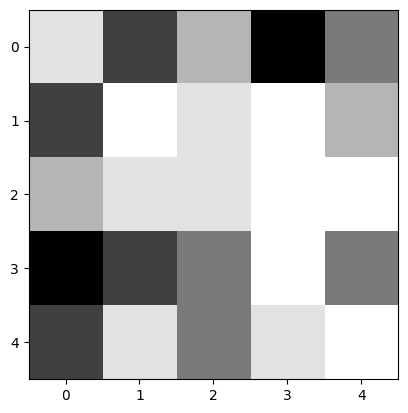

In [436]:
plt.imshow(format_to_img(W[10]), cmap="Greys")

## Gibbs Sampler

In [451]:
def n_tensor(W, C_one_hot, V=25):
    W = W.numpy()
    C_one_hot = C_one_hot.numpy()
    n = np.zeros(shape=(C_one_hot.shape[0], C_one_hot.shape[2], V))
    for v in range(V):
        # print(v)
        for i in range(C_one_hot.shape[1]):
            for d in range(C_one_hot.shape[0]):
                for k in range(C_one_hot.shape[2]):
                    if W[d, i] == v and C_one_hot[d, i, k] == 1:
                        n[d, k, v] += 1
    return n

@tf.function
def tf_N_tensor(W, C_one_hot, V=25):
    
    N_tensor = tf.Variable(tf.zeros(shape=(C_one_hot.shape[0], C_one_hot.shape[2], V)))

    # W = tf.cast(W, dtype=tf.float32) + 1. ## Adding 1 shifting vocab to 1:26, s. t. vectorized removal is possible by product
    # for k in range(C_one_hot.shape[-1]):
    #     temp = W * C_one_hot[:, :, k]
    #     for v in range(1, V+1):
    #         if temp == v:
    #             N_tensor

    for v in range(V):
        # print(v)
        for i in range(C_one_hot.shape[1]):
            for d in range(C_one_hot.shape[0]):
                for k in range(C_one_hot.shape[2]):
                    if W[d, i] == v and C_one_hot[d, i, k] == 1:
                        N_tensor[d, k, v].assign(1.)




In [438]:
W 

<tf.Tensor: shape=(1000, 100), dtype=int32, numpy=
array([[12, 10, 22, ..., 19, 14, 16],
       [18, 16,  8, ..., 17,  3, 14],
       [10, 18,  4, ...,  3, 13,  0],
       ...,
       [13,  8, 19, ..., 16,  1, 21],
       [10, 10,  3, ..., 11, 19, 21],
       [10, 12, 10, ..., 24, 18, 23]])>

In [439]:
N_iter = 100
Theta_store = []
W_ = W

In [440]:
C0  = np.random.randint(0, 10,  size=(D, N))
C0_one_hot = tf.one_hot(C0, depth=K, axis=-1)

alpha0 = np.random.randint(0, 10,  size=(D, N))

beta0 = np.random.normal(size=(D, K))


# Pi0 = np.random.normal(size=(D, K))

In [441]:
C0_one_hot.shape

TensorShape([1000, 100, 10])

In [442]:
W1 = tf.cast(W_, dtype=tf.float32) + 1.
W1 * C_one_hot[:, :, 0]

<tf.Tensor: shape=(1000, 100), dtype=float32, numpy=
array([[ 0.,  0.,  0., ..., 20.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  4.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  4., ...,  0.,  0.,  0.],
       [ 0., 13.,  0., ...,  0.,  0.,  0.]], dtype=float32)>

In [443]:
n_tensor(W_, C0_one_hot)

array([[[0., 0., 0., ..., 0., 0., 0.],
        [1., 0., 1., ..., 0., 0., 2.],
        [0., 0., 0., ..., 0., 1., 1.],
        ...,
        [0., 0., 1., ..., 1., 0., 1.],
        [0., 0., 0., ..., 0., 0., 2.],
        [1., 1., 0., ..., 0., 0., 0.]],

       [[0., 1., 0., ..., 3., 0., 1.],
        [1., 0., 0., ..., 1., 0., 0.],
        [1., 2., 0., ..., 0., 0., 0.],
        ...,
        [1., 0., 0., ..., 1., 0., 0.],
        [0., 1., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 1., 1., 0.]],

       [[1., 0., 1., ..., 0., 0., 0.],
        [0., 0., 1., ..., 1., 0., 0.],
        [0., 1., 1., ..., 1., 1., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 2., 0., ..., 0., 1., 0.],
        [1., 1., 0., ..., 1., 0., 0.],
        [0., 0., 1., ..., 1., 0., 2.],
        ...,
        [0., 0., 2., ..., 0., 0., 0.],
        [1., 1., 2., ..., 0., 0., 0.],
        [1., 0., 1., ..., 0., 1.

In [ ]:
for iter in range(N_iter):
    Ndkv = 
    Theta_it = tfd.Dirichlet()